# 03 - web scraping and data transformations

1. [The TSA posts passenger numbers](https://www.tsa.gov/coronavirus/passenger-throughput) in a table but there is no download or API option. We can use BeautifulSoup to parse this table.
1. Transform the TSA passenger data in two ways to create two different charts
1. Create two charts inside this notebook with [Matplotlib](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

__Library reference__
- [BeautifulSoup]()
- [pandas]()
- [Matplot for pandas]()
- [Datetime format codes](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes)

1. Turn the TSA's html table into a dataframe
    1. Create a list of column names
    1. Create a 2d array of data
    1. Format the data into two columns: date and value
1. Transform the data in two different ways for new different charts
1. Create two charts

In [44]:
# !pipenv uninstall matplotlib

In [45]:
#### Import libraries

from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import requests

# set display format for numbers
# suppress scientific notation

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Turn the TSA's html table into a dataframe

In [46]:
# get html from from page

tsa_r = requests.get('https://www.tsa.gov/coronavirus/passenger-throughput')

In [47]:
# create a beautifulsoup object
doc = BeautifulSoup(tsa_r.text, 'html.parser')

In [48]:
doc

<!DOCTYPE html>

<html dir="ltr" lang="en" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# ">
<head>
<meta charset="utf-8"/>
<script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-34936050-1"></script>
<script>window.dataLayer = window.dataLayer || [];function gtag(){dataLayer.push(arguments)};gtag("js", new Date());gtag("config", "UA-34936050-1", {"groups":"default","anonymize_ip":true,"allow_ad_personalization_signals":false});</script>
<link href="https://www.tsa.gov/coronavirus/passenger-throughput" rel="canonical"/>
<script>var pfHeaderImgUrl = '/sites/default/files/tsa_insignia_rgb_whitespace_0.svg';var pfHeaderTagline = '';var pfdisableClickToDel  

#### table tag
![table selected](../answers/assets/table.png)

### a. Create a list column names

In [49]:
# turn thead into a column list

thead = doc.find('thead')

In [50]:
# then find all th elements (because there is only 1 row)
ths = thead.find_all('th')

In [51]:
# and loop through each th to extract the text for a list
tsa_col = []

for th in ths:
    tsa_col.append(th.text.strip())

In [52]:
# print the list
tsa_col

['Date',
 '2021 Traveler Throughput',
 '2020 Traveler Throughput',
 '2019 Traveler Throughput']

### b. Create a 2d array of data
![tbody example](../answers/assets/tbody.png)

In [53]:
# turn data into an array of arrays (2d array)
tbody = doc.find('tbody')

In [54]:
# turn tr tags into a list
trs = tbody.find_all('tr')

In [55]:
# create a list of td tags inside each tr list
tr_list = []
for tr in trs:
    tds = tr.find_all('td')
    td_list = []
    for td in tds:
        td_list.append(td.text.strip())
    tr_list.append(td_list)

In [56]:
# Check the length of the list and the first couple of items
len(tr_list), tr_list[0:2]

(365,
 [['7/15/2021', '2,152,053', '706,164', '2,716,828'],
  ['7/14/2021', '1,900,945', '589,285', '2,522,563']])

In [57]:
tr_list[0:5]

#we have three columns of data but not easily transformable. Better to have two columns - one column = date, one column = throughput value

[['7/15/2021', '2,152,053', '706,164', '2,716,828'],
 ['7/14/2021', '1,900,945', '589,285', '2,522,563'],
 ['7/13/2021', '1,832,878', '540,268', '2,447,177'],
 ['7/12/2021', '2,093,066', '697,985', '2,615,115'],
 ['7/11/2021', '2,198,635', '754,545', '2,669,717']]

### c. Format the data into two columns: date and value

In [58]:
# create a function that will generate dates of preceding years
def format_date(d, column_year):
    # turn string into date object so we can perform datetime calculations on it
    d = datetime.date(datetime.strptime(d, '%m/%d/%Y'))

    # how many years past
    year_delta = d.year - column_year

    # you can apply addition and subtraction to get x-number of dates from/since now
    d = d - timedelta(weeks=52*year_delta)

    return d

In [59]:
print(tr_list[0][1:])

['2,152,053', '706,164', '2,716,828']


In [60]:
# # this double loop can be combined with the loop above that generates tr_list
# # but i want to separate text extraction from formatting
# passengers_per_day = []
# # for each tr
# for tr in tr_list:
#     # we need to find dates for 2020 and 2019 and align them with the html table format
#     # turn string into date object so we can perform datetime calculations on it
#     #print(tr)
#     #data is always in position 0
#     date_2021 = tr[0]
#     #print(type(date_2021)) #this is a string
#     date_2021 = datetime.strptime(tr[0], '%m/%d/%Y')
#     # the date for 2020 will be 52 weeks before 
#     date_2020 = date_2021 - timedelta(weeks = 52)  
#     #check if days of the week line up...
#     # the date for 2019 will be 104 weeks before
#     date_2019 = date_2021 - timedelta(weeks = 104)
#     #print(date_2021, date_2020, date_2019)
#     # because the above is a repeatable process, how can move this to a function?
#     #print(tr[1:])
#     date_list  = [date_2021, date_2020, date_2019]
#     # for each passenger column td_list[1:]
#     for (index, passenger_column) in enumerate(tr[1:]):
#         # Create a new dictionary to populate with formatted date
#         # index being the column that corresponds to the order of dates in the date_list above
#         daily_passengers = {
#             'date': date_list[index],
#             'value': td.replace(',', '')
#         }
#         #print(daily_passengers)
       
#         # if value does exist, change it to an integer (or else there will be an error on missing values)
#         if(daily_passengers['value'] != ''):
#             daily_passengers['value'] = int(daily_passengers['value'])
#             # add each newly created dictionary to passengers_per_day list
#             passengers_per_day.append(daily_passengers)

In [61]:
# this double loop can be combined with the loop above that generates tr_list
# but i want to separate text extraction from formatting
passengers_per_day = []
# for each tr
for td_list in tr_list:
    # we need to find dates for 2020 and 2019 and align them with the html table format
    # turn string into date object so we can perform datetime calculations on it
    date_2021 = datetime.date(datetime.strptime(td_list[0], '%m/%d/%Y'))
    # the date for 2020 will be 52 weeks before 
    date_2020 = date_2021 - timedelta(weeks=52)
    # the date for 2019 will be 104 weeks before
    date_2019 = date_2021 - timedelta(weeks=104)
    # because the above is a repeatable process, how can move this to a function?
    
    date_list = [format_date(td_list[0], 2021),
                 format_date(td_list[0], 2020),
                 format_date(td_list[0], 2019)]
    
    # for each passenger column td_list[1:]
    for (index, td) in enumerate(td_list[1:]):
        # Create a new dictionary to populate with formatted date
        # index being the column that corresponds to the order of dates in the date_list above
        daily_passengers = {
            'date': date_list[index],
            'value': td.replace(',', '')
        }
        
        # if value does exist, change it to an integer (or else there will be an error on missing values)
        if(daily_passengers['value'] != ''):
            daily_passengers['value'] = int(daily_passengers['value'])
            
            # add each newly created dictionary to passengers_per_day list
            passengers_per_day.append(daily_passengers)

In [62]:
len(passengers_per_day)

926

In [63]:
# turn passengers_per_day into a DataFrame with "date" "value" columns
df = pd.DataFrame(passengers_per_day)

In [64]:
# sort dates from latest to earliest
df = df.sort_values('date', ascending= True)

In [65]:
len(df), len(df['date'].unique())
#looks like there are duplicate dates somewhere

(926, 924)

In [66]:
df[df.duplicated()]

,date,value
925,2019-07-18,2716828
1,2020-07-16,706164


In [67]:
# delete duplicates
df = df.drop_duplicates(subset=['date'])

In [68]:
len(df), len(df['date'].unique())

(924, 924)

In [69]:
#check out values column
df[df['value'].isna()]

,date,value


In [70]:
df[df['value'] == 0]

,date,value


In [71]:
# print(tr_list[0][1:])
print(tr_list[0][1:])

['2,152,053', '706,164', '2,716,828']


## 2. Transform the data in two different ways for two different charts
[What's moving average and why are they used? - Dallas FED](https://www.dallasfed.org/research/basics/moving.aspx)

### a. Calculate 7-day moving average

In [72]:
# display the last 7 rows
df.tail(7)

,date,value
18,2021-07-09,2147903
15,2021-07-10,1987652
12,2021-07-11,2198635
9,2021-07-12,2093066
6,2021-07-13,1832878
3,2021-07-14,1900945
0,2021-07-15,2152053


In [73]:
# write a function that takes the current date and 6 previous dates and averages them
def moving_average(row):
    sum_ = 0
    for i in range(0, 7):
        new_date = row['date'] - timedelta(days=i)
        sum_ = sum_ + df[df['date'] == new_date]['value'].item()
    row['7day_average'] = int(sum_ / 7)
    return row

[Read up on pandas' apply method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)

In [74]:
# calculate 7-day moving average in a new column and start 7 days in (note: result_type apply)
df_average = df[7:].apply(moving_average, axis=1, result_type='reduce')

# set the date as the index for matplot
df_average = df_average.set_index('date')


In [75]:
df_average

,value,7day_average
date,,
2019-01-11,1733739,2097272
2019-01-12,1739642,2010777
2019-01-13,1955200,1975504
2019-01-14,1959788,1948250
2019-01-15,1604862,1895237
...,...,...
2021-07-11,2198635,2041681
2021-07-12,2093066,2032098
2021-07-13,1832878,2023951


### b. Group data by weeks

In [76]:
# create a function to get day of the first day of the week
def weekday_start(row):
    row['week_number'] = row['date'].isocalendar()[1]
    try:
        row['week_start'] = datetime.fromisocalendar(row['date'].year, row['date'].isocalendar()[1], 1)
    except:
        row['week_start'] = datetime.fromisocalendar(row['date'].year, 1, 1)
    return row

In [77]:
# create a new column that IDs the start date of the week
df_weeks = df.apply(weekday_start, axis=1, result_type='reduce')

In [78]:
# groupby week start turn the groupby object into a dataframe
df_by_week = pd.DataFrame(df_weeks.groupby('week_start')['value'].sum())

## 3. Create two charts - one for 7-day moving average and one for week totals
Create a bar chart of the daily values for reference

<AxesSubplot:xlabel='date'>

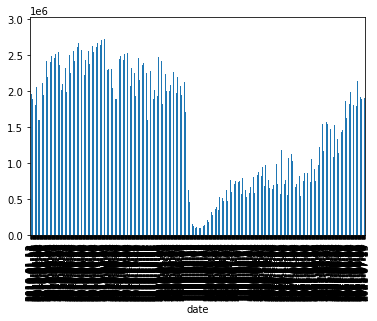

In [79]:
import matplotlib.pyplot as plt
# create a bar chart for daily values
plt.figure()
df_average['value'].plot(kind='bar')

### a. 7-day moving average

<AxesSubplot:xlabel='date'>

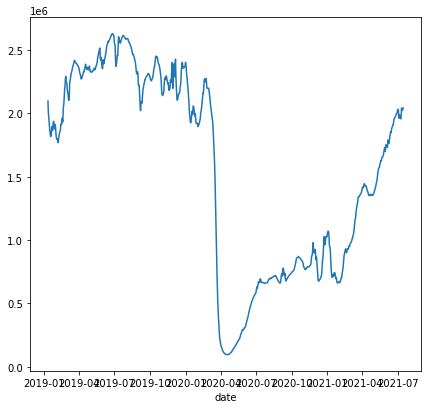

In [80]:
# plot a 7-day average line chart
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
df_average['7day_average'].plot(ax=ax)

### b. By weekly totals

<AxesSubplot:xlabel='week_start'>

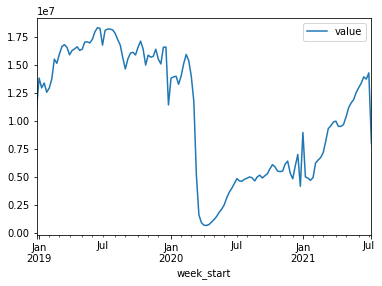

In [81]:
# plot as weeks as a line chart
plt.figure
df_by_week.plot()